In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
%config InlineBackend.figure_formats = ['svg']

# Precipitation Evaluation

In this notebook, we show how we generate precipitation statistics plot, i.e., Figure 6 in "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation", Hu et al. 2024, arXiv preprint:2306.08754.

## Set data path

All the simulation output, saved model weights, and preprocessed data used in Hu et al. 2024 "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation" are provided in a hu_etal2024_data folder that you can download. Please change the following path to your downloaded hu_etal2024_data folder.

In [2]:
data_path = '/global/homes/z/zeyuanhu/scratch/hu_etal2024_data/'

In [3]:
ds_grid = xr.open_dataset(data_path+'data_grid/ne4pg2_scrip.nc')
grid_area = ds_grid['grid_area']

def zonal_mean_area_weighted(data, grid_area, lat):
    # Define latitude bins ranging from -90 to 90, each bin spans 10 degrees
    bins = np.arange(-90, 91, 10)  # Create edges for 10 degree bins

    # Get indices for each lat value indicating which bin it belongs to
    bin_indices = np.digitize(lat.values, bins) - 1

    # Initialize a list to store the zonal mean for each latitude bin
    data_zonal_mean = []

    # Iterate through each bin to calculate the weighted average
    for i in range(len(bins)-1):
        # Filter data and grid_area for current bin
        mask = (bin_indices == i)
        data_filtered = data[mask]
        grid_area_filtered = grid_area[mask]

        # Check if there's any data in this bin
        if data_filtered.size > 0:
            # Compute area-weighted average for the current bin
            weighted_mean = np.average(data_filtered, axis=0, weights=grid_area_filtered)
        else:
            # If no data in bin, append NaN or suitable value
            weighted_mean = np.nan

        # Append the result to the list
        data_zonal_mean.append(weighted_mean)

    # Convert list to numpy array
    data_zonal_mean = np.array(data_zonal_mean)

    # The mid points of the bins are used as the representative latitudes
    lats_mid = bins[:-1] + 5

    return data_zonal_mean, lats_mid

ds2 = xr.open_dataset(data_path+'data_grid/E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2.eam.h0.0001-01.nc')
lat = ds2.lat
lon = ds2.lon
level = ds2.lev.values

def zonal_mean(var):
    var_re = var.reshape(-1,384,var.shape[-1])
    var_re = np.transpose(var_re, (1,0,2))
    var_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_re, grid_area, lat)
    return var_zonal_mean, lats_sorted


## Read the 5-year U-Net hybrid simulation and MMF reference simulation monthly data

Calculate the 5-year zonal mean precipitation climatology globally, over ocean, and over land

In [4]:
filenames = data_path+'h0/5year/unet_v5/huber_rop/*.eam.h0.000[3-8]*.nc'
ds_nn = xr.open_mfdataset(filenames)

# Exclude the first month (0003-01) due to spin model
ds_nn = ds_nn.sel(time=ds_nn.time[1:])
ds_nn['lev'].attrs['long_name'] = 'hybrid pressure'

filenames = data_path+'h0/5year/mmf_ref/*.eam.h0.000[3-8]*.nc'
ds_sp = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01) due to spin model
ds_sp = ds_sp.sel(time=ds_sp.time[1:])
ds_sp['lev'].attrs['long_name'] = 'hybrid pressure'

In [5]:
# calculate zonal mean precipitation averaged globally, over ocean, and over land.
sp_tmean = (ds_sp['PRECC']+ds_sp['PRECL']).mean(dim=('time')).compute()
nn_tmean = (ds_nn['PRECC']+ds_nn['PRECL']).mean(dim=('time')).compute()
sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
scaling = 86400*1000
land_frac = ds_sp.LANDFRAC[2].compute().values
ocean_frac = 1 - land_frac
sp_zm_land, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area*land_frac, lat)
nn_zm_land, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area*land_frac, lat)
sp_zm_ocean, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area*ocean_frac, lat)
nn_zm_ocean, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area*ocean_frac, lat)

data_sp = scaling*xr.DataArray(sp_zm, dims=["latitude"],
                                   coords={"latitude": lats_sorted})
data_nn = scaling*xr.DataArray(nn_zm, dims=["latitude"],
                                   coords={"latitude": lats_sorted})

data_sp_land = scaling*xr.DataArray(sp_zm_land, dims=["latitude"],
                                   coords={"latitude": lats_sorted})
data_nn_land = scaling*xr.DataArray(nn_zm_land, dims=["latitude"],
                                   coords={"latitude": lats_sorted})

data_sp_ocean = scaling*xr.DataArray(sp_zm_ocean, dims=["latitude"],
                                   coords={"latitude": lats_sorted})
data_nn_ocean = scaling*xr.DataArray(nn_zm_ocean, dims=["latitude"],
                                   coords={"latitude": lats_sorted})


## Read the 5-year U-Net hybrid simulation and MMF reference simulation hourly data

Read the data and area weights to generate histogram of precipitation.

In [6]:
ds_sp_prect = xr.open_mfdataset(data_path+'precip_hourly/mmf_ref/PRECT*nc')
ds_nn_prect = xr.open_mfdataset(data_path+'precip_hourly/unet_v5/huber_rop/PRECT*nc')

data_sp_h2 = ds_sp_prect.PRECT.compute().values * 86400 * 1000  # Convert to mm/day
data_nn_h2 = ds_nn_prect.PRECT.compute().values * 86400 * 1000  # Convert to mm/day

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

land_frac = ds_sp.LANDFRAC[2].compute().values  # Example, replace with the actual land_frac array
ocean_frac = 1 - land_frac

# Flatten the data
data_sp_flat = data_sp_h2.flatten()
data_nn_flat = data_nn_h2.flatten()

# Repeat the grid_area to match the length of the flattened data
weights_sp = np.tile(grid_area, data_sp_h2.shape[0])
weights_nn = np.tile(grid_area, data_nn_h2.shape[0])

# Global weights
weights_sp_global = weights_sp
weights_nn_global = weights_nn

# Land weights
weights_sp_land = weights_sp * np.tile(land_frac, data_sp_h2.shape[0])
weights_nn_land = weights_nn * np.tile(land_frac, data_nn_h2.shape[0])

# Ocean weights
weights_sp_ocean = weights_sp * np.tile(ocean_frac, data_sp_h2.shape[0])
weights_nn_ocean = weights_nn * np.tile(ocean_frac, data_nn_h2.shape[0])


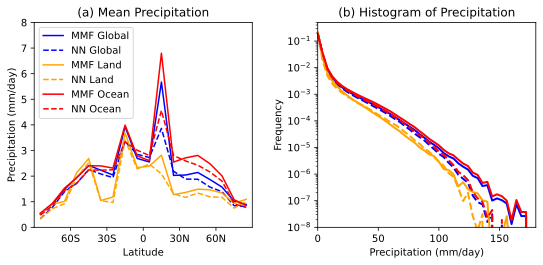

In [8]:
# Define latitude ticks and labels
lat_ticks = [-60, -30, 0, 30, 60]
lat_labels = ['60S', '30S', '0', '30N', '60N']

# Create figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.7))

# First plot: Zonal mean precipitation
ax1 = axes[0]
# ax1.plot(lats_sorted, data_sp, label='MMF Global', color='blue', linestyle='-', marker='o')
# ax1.plot(lats_sorted, data_nn, label='NN Global', color='blue', linestyle='--', marker='x')
# ax1.plot(lats_sorted, data_sp_land, label='MMF Land', color='orange', linestyle='-', marker='o')
# ax1.plot(lats_sorted, data_nn_land, label='NN Land', color='orange', linestyle='--', marker='x')
# ax1.plot(lats_sorted, data_sp_ocean, label='MMF Ocean', color='red', linestyle='-', marker='o')
# ax1.plot(lats_sorted, data_nn_ocean, label='NN Ocean', color='red', linestyle='--', marker='x')
ax1.plot(lats_sorted, data_sp, label='MMF Global', color='blue', linestyle='-')# , marker='o')
ax1.plot(lats_sorted, data_nn, label='NN Global', color='blue', linestyle='--')# , marker='x')
ax1.plot(lats_sorted, data_sp_land, label='MMF Land', color='orange', linestyle='-')# , marker='o')
ax1.plot(lats_sorted, data_nn_land, label='NN Land', color='orange', linestyle='--')# , marker='x')
ax1.plot(lats_sorted, data_sp_ocean, label='MMF Ocean', color='red', linestyle='-')# , marker='o')
ax1.plot(lats_sorted, data_nn_ocean, label='NN Ocean', color='red', linestyle='--')# , marker='x')

ax1.set_xlabel('Latitude')
ax1.set_ylabel('Precipitation (mm/day)')
ax1.set_xticks(lat_ticks)
ax1.set_xticklabels(lat_labels)
ax1.set_title('(a) Mean Precipitation')
ax1.legend()
ax1.set_ylim(0, 8)
ax1.set_xlim(-90,90)
# Second plot: Weighted histogram of precipitation
ax2 = axes[1]
bins_lev = np.arange(-2,180,4)
def plot_histogram(ax, data_flat, weights, label, color, linestyle):
    hist, bins = np.histogram(data_flat, bins=bins_lev, weights=weights, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax.plot(bin_centers, hist, label=label, color=color, linestyle=linestyle, linewidth=2)

plot_histogram(ax2, data_sp_flat, weights_sp_global, 'MMF Global', 'blue', '-')
plot_histogram(ax2, data_nn_flat, weights_nn_global, 'NN Global', 'blue', '--')
plot_histogram(ax2, data_sp_flat, weights_sp_land, 'MMF Land', 'orange', '-')
plot_histogram(ax2, data_nn_flat, weights_nn_land, 'NN Land', 'orange', '--')
plot_histogram(ax2, data_sp_flat, weights_sp_ocean, 'MMF Ocean', 'red', '-')
plot_histogram(ax2, data_nn_flat, weights_nn_ocean, 'NN Ocean', 'red', '--')

ax2.set_yscale('log')
ax2.set_xlabel('Precipitation (mm/day)')
ax2.set_ylabel('Frequency')
ax2.set_title('(b) Histogram of Precipitation')
ax2.set_ylim(1e-8,0.5)
ax2.set_xlim(0,180)

# Adjust layout
# plt.tight_layout()
plt.subplots_adjust(wspace=0.3)  # Adjust the width space between subplots
# Show plot
# plt.savefig('precipitation_distribution_hist_nopruning_noclass.eps', format='eps', dpi=600)
plt.show()
